In [ ]:
# library(Seurat)
# library(monocle)
# library(patchwork)
# library(dplyr)
# library(plotly)
# library(ggplot2)
# cds <- readRDS("../6.monocle/M-MG_monocle.rds")
# if (!exists("cds"))
#   stop("请先加载已有的 CellDataSet 对象到变量 cds")

# # 检查 pseudotime 字段名称（新旧版本差异）
# ptime_col <- if ("Pseudotime" %in% colnames(pData(cds))) "Pseudotime" else
#   if ("State_Pseudotime" %in% colnames(pData(cds))) "State_Pseudotime" else
#     stop("cds 中未找到 Pseudotime 列，请确认已运行 orderCells()")

# map_df <- data.frame(
#   cell_id    = rownames(pData(cds)),
#   pseudotime = pData(cds)[[ptime_col]],
#   stringsAsFactors = FALSE
# )

# # 去掉没有 pseudotime 的细胞（一般是 root 未覆盖）——可选
# map_df <- subset(map_df, !is.na(pseudotime))

# # 写出 CSV
# out_fn <- "cds_pseudotime_mapping.csv"
# write.csv(map_df, file = out_fn, row.names = FALSE)
# cat(sprintf("已写出 %s（共 %d 条记录）\n", out_fn, nrow(map_df)))

In [1]:
import sys, os
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import re, warnings
# ---------- 参数 ----------

In [ ]:
dataset = 'R-CG'
datasetlist = [dataset]
n_stages = 20
MAPPING_FILE = "cds_pseudotime_mapping.csv"   # 上一步生成
AD_IN        = f"../1.subset/{dataset}_cleaned.h5ad"             
AD_OUT       = f"{dataset}_cleaned_pse.h5ad"                
group_key   = "pse_stage"                 
method      = "wilcoxon"
TOP_N       = 10
pval_cutoff = 0.01
lfc_cutoff  = 0.25
if_subcelltype = True
lingage_name='HR-SEC'
subcelltype=[            "CSC",
                     "LumSEC-Lip-CG",
                     "Lum-Tm4sf4",
                     "Lum-Stat4",
]
# --------------------------
sc.settings.figdir = ''

In [ ]:
def plot_umap_without_borders(ea, dataset, color="newcelltype"):
    """
    绘制没有边框、标题的 UMAP 图，在左下角添加一个坐标轴。
    返回 Figure 对象。
    """

    # 使用 scanpy 的绘图函数，返回 Figure 对象
    fig = sc.pl.umap(
        ea,
        color=color,
        size=3,
        show=False,          # 不直接展示
        return_fig=True,# 返回 Figure 对象
        cmap='plasma'
    )

    # 获取主绘图区
    ax = fig.axes[0]

    # 删除标题
    ax.set_title("")

    # 删除坐标轴刻度和标签
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("")
    ax.set_ylabel("")

    # 删除边框
    for spine in ax.spines.values():
        spine.set_visible(False)

    # 在左下角添加一个坐标轴
    arrow_length = 0.2  # 坐标轴长度
    arrow_x_start = 0.05  # 箭头起点的 x 坐标（相对轴的范围）
    arrow_y_start = 0.05  # 箭头起点的 y 坐标

    # 绘制箭头（UMAP1）
    ax.annotate(
        "", xy=(arrow_length, 0), xytext=(0, 0),
        arrowprops=dict(facecolor="black", shrink=0, width=1, headwidth=5),
        xycoords="axes fraction", textcoords="axes fraction",
        annotation_clip=False
    )

    # 绘制箭头（UMAP2）
    ax.annotate(
        "", xy=(0, arrow_length), xytext=(0, 0),
        arrowprops=dict(facecolor="black", shrink=0, width=1, headwidth=5),
        xycoords="axes fraction", textcoords="axes fraction",
        annotation_clip=False
    )

    # 添加标签（UMAP1 和 UMAP2）
    ax.text(
        arrow_x_start + 0.2, arrow_y_start, "UMAP1",
        fontsize=10, ha="center", va="center", transform=ax.transAxes
    )
    ax.text(
        arrow_x_start, arrow_y_start + 0.2, "UMAP2",
        fontsize=10, ha="center", va="center", transform=ax.transAxes
    )

    # 返回修改后的 Figure
    return fig

In [ ]:
def export_deg_result(adata):
    result = adata.uns['rank_genes_groups']
    groups = result['names'].dtype.names
    data = []
    for group in groups:
        genes = result['names'][group]
        logfoldchanges = result['logfoldchanges'][group]
        pvals = result['pvals'][group]
        pvals_adj = result['pvals_adj'][group]
        for gene, lfc, pval, pval_adj in zip(genes, logfoldchanges, pvals, pvals_adj):
            data.append([group, gene, lfc, pval, pval_adj])
    df = pd.DataFrame(data, columns=['group', 'gene', 'logfoldchange', 'pval', 'pval_adj'])
    df1 = df[df['pval'] < 0.01]
    return df1

In [37]:
# 载入数据
if not os.path.exists(MAPPING_FILE):
    sys.exit(f"找不到映射文件 {MAPPING_FILE}")

map_df = pd.read_csv(MAPPING_FILE)
adata  = sc.read_h5ad(AD_IN)

# 确保细胞 ID 用作索引
map_df = map_df.set_index("cell_id")

In [40]:
# 找到共用细胞
common_ids = adata.obs_names.intersection(map_df.index)

# 过滤 adata（只保留匹配成功的细胞）
adata = adata[common_ids].copy()

# 写入 pseudotime
adata.obs["pseudotime"] = map_df.loc[common_ids, "pseudotime"].values
if(if_subcelltype):
    adata=adata[adata.obs['newcelltype'].isin(subcelltype),:].copy()


✅ 已保存 D:/111/M-MG_cleaned_pse.h5ad，共 7395 个细胞


In [41]:
labels = [f"pse_{i+1}" for i in range(n_stages)]

adata.obs["pse_stage"] = pd.qcut(
    adata.obs["pseudotime"],
    q=n_stages,
    labels=labels,
    duplicates="drop"    # 如果有重复的分位点，就自动合并掉多余的箱
)
# 保存
adata.write(AD_OUT)
print(f"✅ 已保存 {AD_OUT}，共 {adata.n_obs} 个细胞")

✅ 已保存 D:/111/M-MG_cleaned_pse.h5ad，共 7395 个细胞


In [44]:
stage_cmap = sns.color_palette("plasma", n_colors=5)  # 紫→黄渐变

print("===== 处理样本 =====")
for ds in datasetlist:
    print(f"--- {ds} ---")
    if "normalized" not in adata.layers:
        warnings.warn("未找到 'normalized' 层，直接使用当前 X。")
    else:
        adata.X = adata.layers["normalized"].copy()

    if group_key not in adata.obs.columns:
        warnings.warn(f"{group_key} 不存在，跳过。")
        continue

    # 确保 pse_1…pse_5 顺序
    stages = sorted(adata.obs[group_key].unique(), key=lambda x: int(re.sub(r"[^0-9]", "", str(x))))
    adata.obs[group_key] = pd.Categorical(adata.obs[group_key], categories=stages, ordered=True)

    # --- DEG 计算 ---
    key_added = f"rank_{group_key}"
    sc.tl.rank_genes_groups(
        adata,
        groupby   = group_key,
        method    = method,
        pts       = True,
        key_added = key_added,
        
    )

    # 每阶段提取 TOP_N 基因
    stage_top = {}
    for st in stages:
        df = sc.get.rank_genes_groups_df(adata, group=st, key=key_added)
        sig = df[(df.pvals_adj < pval_cutoff) & (df.logfoldchanges > lfc_cutoff)]
        stage_top[st] = sig.sort_values("scores", ascending=False).names.head(TOP_N).tolist()

    gene_union = pd.unique(np.concatenate(list(stage_top.values())))
    if len(gene_union) == 0:
        print("无显著基因，跳过绘图。")
        continue

    # --- 计算表达矩阵 gene × stage ---
    expr = pd.DataFrame(index=gene_union, columns=stages, dtype=float)
    var_lookup = pd.Series(range(adata.n_vars), index=adata.var_names)
    for st in stages:
        cells = adata.obs_names[adata.obs[group_key] == st]
        mat   = adata[cells].X  # 已替换为 normalized
        mean_vec = np.asarray(mat.mean(axis=0)).ravel()
        idx = expr.index.intersection(adata.var_names)
        expr.loc[idx, st] = mean_vec[var_lookup[idx].values]
    expr = expr.fillna(0)

    # Z-score (行)
    expr_z = expr.sub(expr.mean(axis=1), axis=0)
    expr_z = expr_z.div(expr_z.std(axis=1).replace(0, 1), axis=0)

        # --- 绘图 ---
    n_rows, n_stage = expr_z.shape[0], len(stages)
    fig_h = max(5, n_rows * 0.25 + 1)
    fig_w = max(4, n_stage * 0.9 + 1)
    
    fig = plt.figure(figsize=(fig_w, fig_h))
    
    # 主列(热图+渐变条) + 右窄列(colorbar)
    gs = gridspec.GridSpec(
        2, 2,
        height_ratios=[n_rows, 1],    # 第二行就是渐变条
        width_ratios=[1, 0.06],
        hspace=0.05,                  # 贴近一些
        wspace=0.05
    )
    
    # ── Heatmap ───────────────────────────────────────
    ax_hm   = fig.add_subplot(gs[0, 0])
    cbar_ax = fig.add_subplot(gs[0, 1])
    
    sns.heatmap(
        expr_z,
        ax=ax_hm,
        cmap="RdBu_r",
        center=0, vmin=-2, vmax=2,
        linewidths=0.4,
        cbar_ax=cbar_ax,
        cbar_kws=dict(label="Z‑score")
    )
    ax_hm.set_xticks([]); ax_hm.set_xlabel("")
    ax_hm.tick_params(axis="x", bottom=False, top=False)
    ax_hm.set_ylabel("Gene")
    ax_hm.set_title(f"{ds}  |  Top {TOP_N} genes by pse_stage", pad=10)
    
    # ── 底部渐变条 ────────────────────────────────────
    ax_bar = fig.add_subplot(gs[1, 0])
    ax_bar.imshow(
        np.arange(n_stage).reshape(1, -1),
        aspect="auto",
        cmap=sns.color_palette("plasma", as_cmap=True),
        extent=[0, n_stage, 0, 1]
    )
    ax_bar.set_xlim(ax_hm.get_xlim())
    ax_bar.set_xticks(np.arange(n_stage) + 0.5)
    ax_bar.set_xticklabels(stages, rotation=45, ha="center", fontsize=9)
    ax_bar.set_yticks([])
    for spine in ax_bar.spines.values():
        spine.set_visible(False)
    
    plt.tight_layout()
    fig.savefig(f"{ds}_{lingage_name}_pse_stage_heatmap.png", dpi=300)
    fig.savefig(f"{ds}_{lingage_name}_pse_stage_heatmap.pdf", dpi=300)
    plt.close(fig)
    df1 = sc.get.rank_genes_groups_df(adata=adata,pval_cutoff=pval_cutoff,log2fc_min=lfc_cutoff,key=key_added,group=None)
    df1.to_csv(f'{dataset}_{lingage_name}_pseudotime_genes.csv', index=False)


===== 处理样本 =====
--- M-MG ---
✅ 已保存 heatmaps\M-MG_pse_stage_heatmap.png

🎉 所有样本处理完成！


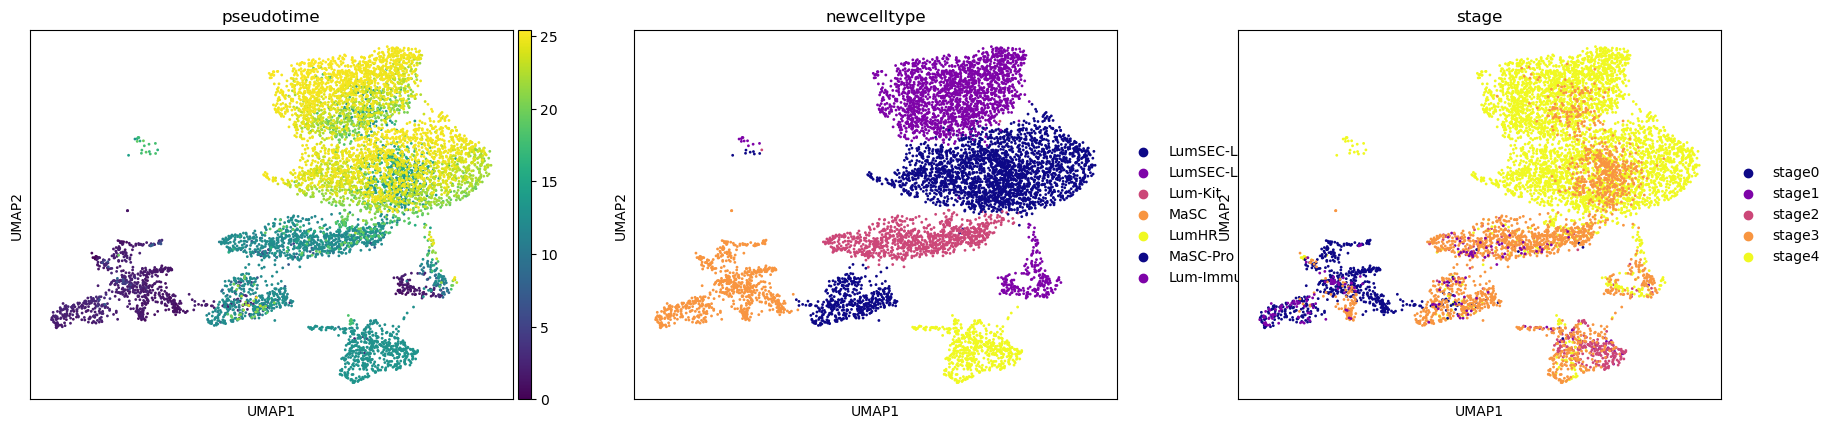

In [52]:
fig1 = plot_umap_without_borders(adata, dataset=dataset, color="pseudotime")

In [ ]:
fig1.savefig(f'{dataset}-{lingage_name}_pseudotime-umap.png', dpi=300, bbox_inches="tight")
fig1.savefig(f'{dataset}-{lingage_name}_pseudotime-umap.pdf', dpi=300, bbox_inches="tight")
plt.close(fig)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_32564\1911417065.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('plasma', n_stages)


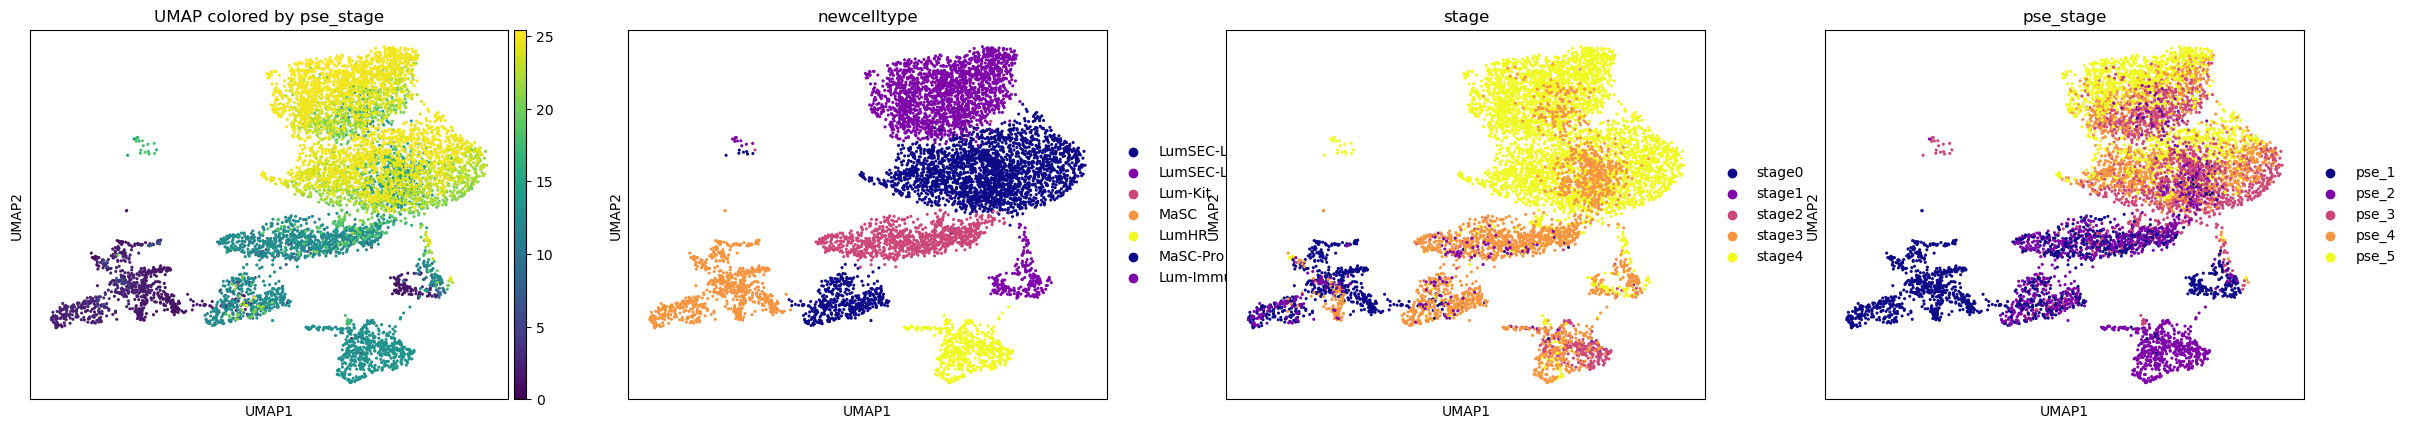

In [50]:
stages = pd.Categorical(adata.obs['pse_stage'], ordered=True)
adata.obs['stage_code'] = stages.codes
n_stages = len(stages.categories)
# Step 2: Generate a gradient palette from a continuous colormap (e.g., viridis)
cmap = plt.cm.get_cmap('plasma', n_stages)
palette = [cmap(i) for i in range(n_stages)]
# Step 3: Plot UMAP using discrete stages but with gradient-based colors
# Use the custom palette; legend shows stage labels
fig=sc.pl.umap(
    adata,
    color=['pse_stage'],
    palette=palette,
    size=20,
    legend_loc='right margin',
    title=f'{dataset}UMAP colored by pse_stage',return_fig=True
)
fig.savefig(f'{dataset}_{lingage_name}_pse-stage_umap.png', dpi=300)
fig.savefig(f'{dataset}_{lingage_name}_pse-stage_umap.pdf', dpi=300)
plt.close(fig) 

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_32564\1911417065.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('plasma', n_stages)


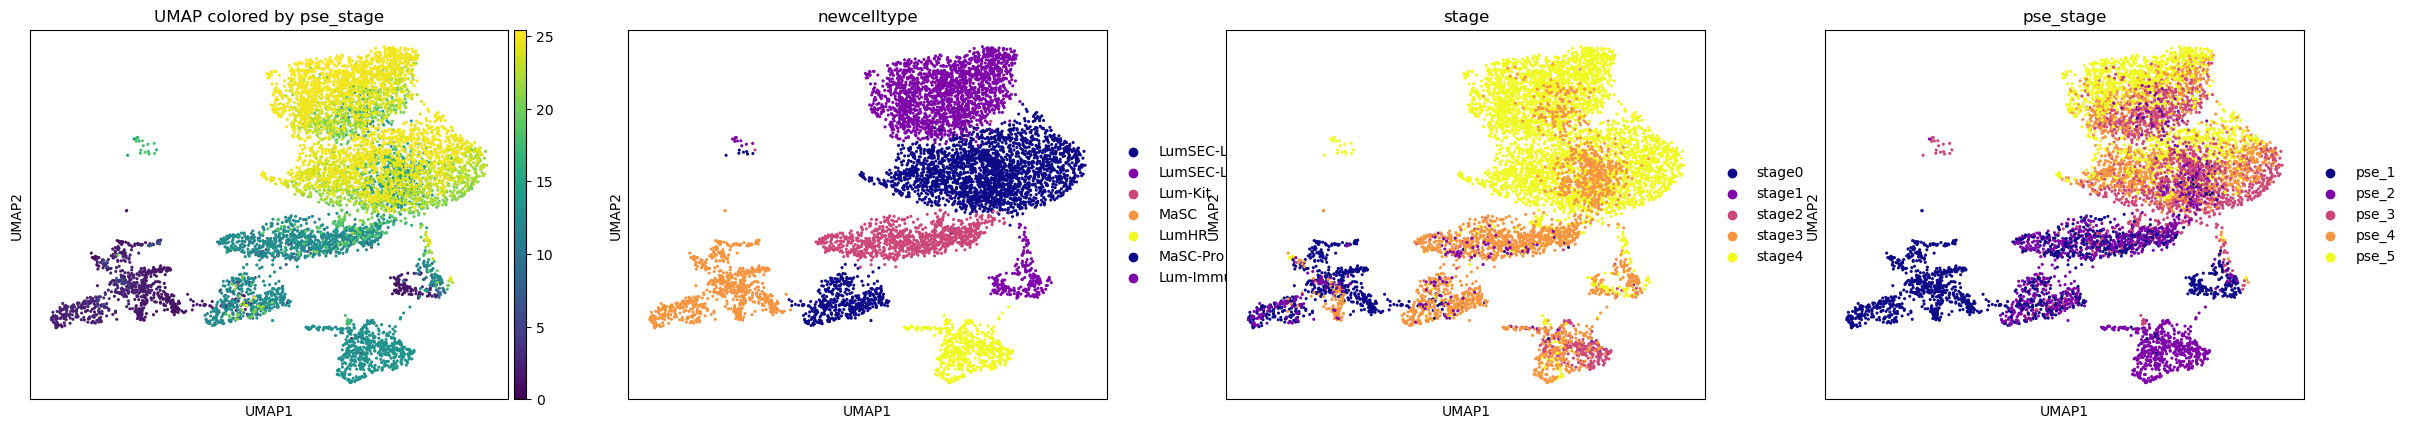

In [50]:
stages = pd.Categorical(adata.obs['pse_stage'], ordered=True)
adata.obs['stage_code'] = stages.codes
n_stages = len(stages.categories)
# Step 2: Generate a gradient palette from a continuous colormap (e.g., viridis)
cmap = plt.cm.get_cmap('plasma', n_stages)
palette = [cmap(i) for i in range(n_stages)]
# Step 3: Plot UMAP using discrete stages but with gradient-based colors
# Use the custom palette; legend shows stage labels
fig=sc.pl.umap(
    adata,
    color=['pseudotime','stage','pse_stage'],
    palette=palette,
    size=20,
    legend_loc='right margin',
    title=f'{dataset}UMAP colored by pse_stage',return_fig=True
)
fig.savefig(f'{dataset}_{lingage_name}_pse-all_umap.png', dpi=300)
fig.savefig(f'{dataset}_{lingage_name}_pse-all_umap.pdf', dpi=300)
plt.close(fig) 